In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)
import logging
import os
import pypsa
import pandas as pd
import networkx as nx
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
from itertools import product
logger = logging.getLogger(__name__)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)
import sys
sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root
sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


This is the repository path:  c:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth
Had to go 1 folder(s) up.


# Load networks from pypsa

In [2]:
solved_network_BAU = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\BAU\elec_s_22_ec_lcopt_Co2L-1H.nc"
solved_network_red20 = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\red20\elec_s_22_ec_lcopt_Co2L-1H.nc"
solved_network_red40 = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\red40\elec_s_22_ec_lcopt_Co2L-1H.nc"
solved_network_red60 = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\red60\elec_s_22_ec_lcopt_Co2L-1H.nc"
solved_network_red80 = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\red80\elec_s_22_ec_lcopt_Co2L-1H.nc"
solved_network_red100 = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\red100\elec_s_22_ec_lcopt_Co2L-1H.nc"

n_solve_BAU = pypsa.Network(solved_network_BAU)
n_solve_red20 = pypsa.Network(solved_network_red20)
n_solve_red40 = pypsa.Network(solved_network_red40)
n_solve_red60 = pypsa.Network(solved_network_red60)
n_solve_red80 = pypsa.Network(solved_network_red80)
n_solve_red100 = pypsa.Network(solved_network_red100)


c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

# Scenario definition

In [3]:
scenario_list = [
    (n_solve_BAU, "BAU"),
    (n_solve_red20, "Red20"),
    (n_solve_red40, "Red40"),
    (n_solve_red60, "Red60"),
    (n_solve_red80, "Red80"),
    (n_solve_red100, "Red100")
]
scenario_list

[(PyPSA Network
  Components:
   - Bus: 66
   - Carrier: 16
   - Generator: 80
   - GlobalConstraint: 1
   - Line: 28
   - Link: 88
   - Load: 22
   - StorageUnit: 6
   - Store: 44
  Snapshots: 8760,
  'BAU'),
 (PyPSA Network
  Components:
   - Bus: 66
   - Carrier: 16
   - Generator: 80
   - GlobalConstraint: 1
   - Line: 28
   - Link: 88
   - Load: 22
   - StorageUnit: 6
   - Store: 44
  Snapshots: 8760,
  'Red20'),
 (PyPSA Network
  Components:
   - Bus: 66
   - Carrier: 16
   - Generator: 80
   - GlobalConstraint: 1
   - Line: 28
   - Link: 88
   - Load: 22
   - StorageUnit: 6
   - Store: 44
  Snapshots: 8760,
  'Red40'),
 (PyPSA Network
  Components:
   - Bus: 66
   - Carrier: 16
   - Generator: 80
   - GlobalConstraint: 1
   - Line: 28
   - Link: 88
   - Load: 22
   - StorageUnit: 6
   - Store: 44
  Snapshots: 8760,
  'Red60'),
 (PyPSA Network
  Components:
   - Bus: 66
   - Carrier: 16
   - Generator: 80
   - GlobalConstraint: 1
   - Line: 28
   - Link: 88
   - Load: 22
   - Sto

# Capacity comparison for 2050 

In [4]:
#MW
def filter_capacities(scenario_pypsa,scenario_name):
    capacities_pypsa = pd.DataFrame(scenario_pypsa.statistics.optimal_capacity() - scenario_pypsa.statistics.installed_capacity())

    capacities_pypsa = capacities_pypsa.drop(index=['Line', 'Link','Load','Store'], level=0)
    capacities_pypsa = capacities_pypsa.reset_index(level=0, drop=True)
    capacities_pypsa.rename(columns={0:(scenario_name)}, inplace=True)
    capacities_pypsa.index.name = "Technology"
    capacities_pypsa = capacities_pypsa.drop(index=['load'])
    #capacities_pypsa = capacities_pypsa.drop(index=['battery charger'])
    #capacities_pypsa = capacities_pypsa.drop(index=['H2 electrolysis'])

    return capacities_pypsa

test = filter_capacities(n_solve_BAU,"BAU")
test

,BAU
Technology,
Reservoir & Dam,0.000000
Biomass,1693.944395
Combined-Cycle Gas,1618.747138
Geothermal,0.000018
Oil,452.106629
Onshore Wind,0.662205
Open-Cycle Gas,993.459715
Run of River,0.000000
Solar,5320.146861


In [5]:
filtered_capacities_dict = {}

for scenario,name in scenario_list:
    filtered_capacities = filter_capacities(scenario, name)
    filtered_capacities_dict[name] = filtered_capacities

combined_capacities = pd.concat(filtered_capacities_dict.values(), axis=1)
combined_capacities

,BAU,Red20,Red40,Red60,Red80,Red100
Technology,,,,,,
Reservoir & Dam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Biomass,1693.944395,1693.983044,1693.965309,1693.987138,1693.998555,1693.984066
Combined-Cycle Gas,1618.747138,1585.080863,998.040648,703.128286,486.674017,258.294614
Geothermal,0.000018,313.146696,879.968349,879.917475,879.942976,413.120396
Oil,452.106629,390.534930,311.108262,308.647585,233.199673,142.460068
Onshore Wind,0.662205,0.607352,1.227287,2.309878,2.665616,4.560024
Open-Cycle Gas,993.459715,375.914460,38.074537,23.778259,44.235922,11.080501
Run of River,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Solar,5320.146861,7154.369790,12758.564008,23183.992146,42072.321115,61447.767405


In [6]:
combined_capacities.sum(axis=0)

BAU       10079.066961
Red20     11513.637135
Red40     16680.948401
Red60     26795.760766
Red80     45413.037874
Red100    63971.267075
dtype: float64

# Storage comparison for 2050

In [7]:
#MWh
def filter_storage_capacities(scenario_pypsa,scenario_name):
    
    storage_capacities = pd.DataFrame(scenario_pypsa.statistics.optimal_capacity())
    storage_capacities = storage_capacities.drop(index=['Line','Generator','StorageUnit'], level=0)
    storage_capacities.rename(columns={0:(scenario_name)}, inplace=True)
    storage_capacities

    return storage_capacities

test2 = filter_storage_capacities(n_solve_BAU,"BAU")
test2

BAU
      carrier                         
Store Battery Storage      3296.752739
      Hydrogen Storage    13248.597809
Link  H2 electrolysis       365.375662
      H2 fuel cell          962.804336
      battery charger       697.865859
      battery discharger    775.406511

In [8]:
filtered_storage_capacities_dict = {}

for scenario,name in scenario_list:
    filtered_storage_capacities = filter_storage_capacities(scenario, name)
    filtered_storage_capacities_dict[name] = filtered_storage_capacities

combined_storage_capacities = pd.concat(filtered_storage_capacities_dict.values(), axis=1)
combined_storage_capacities

BAU         Red20         Red40  \
      carrier                                                        
Store Battery Storage      3296.752739   6567.391793  20045.968003   
      Hydrogen Storage    13248.597809  15605.624043  25325.929325   
Link  H2 electrolysis       365.375662    390.550825    841.779269   
      H2 fuel cell          962.804336    810.836234    894.371422   
      battery charger       697.865859   1337.083545   3189.184702   
      battery discharger    775.406511   1485.648384   3543.538558   

                                 Red60          Red80         Red100  
      carrier                                                         
Store Battery Storage     42719.381385   80249.915550  116874.522184  
      Hydrogen Storage    51432.716196  115662.394996  235241.985012  
Link  H2 electrolysis      2162.481898    4499.243678    6962.404868  
      H2 fuel cell         1626.297338    3252.165090    5034.904814  
      battery charger      6780.452272   13012.091160   19070.574144  
      battery discharger   7533.835858   14457.879067   21189.526826

In [9]:
combined_storage_capacities.drop(index=['Link'], level=0).sum(axis=0)

BAU        16545.350548
Red20      22173.015837
Red40      45371.897328
Red60      94152.097581
Red80     195912.310546
Red100    352116.507196
dtype: float64

# Production comparison for 2050

In [10]:
def filter_production(scenario_pypsa,scenario_name):
    production_pypsa = pd.DataFrame(scenario_pypsa.statistics.dispatch())
    production_pypsa = production_pypsa.drop(index=['Line','Load','Link','Store'], level=0)
    production_pypsa = production_pypsa.reset_index(level=0, drop=True)
    production_pypsa.rename(columns={0:('GWh - PyPSA-BO')}, inplace=True)
    production_pypsa.index.name = "Technology"
    production_pypsa = production_pypsa.drop(index=['load'])
    production_pypsa['GWh - PyPSA-BO'] = production_pypsa['GWh - PyPSA-BO']/1000
    #production_pypsa.loc['Total'] = production_pypsa['TWh - PyPSA-BO'].sum()
    production_pypsa.rename(columns={'GWh - PyPSA-BO':(scenario_name)}, inplace=True)

    return production_pypsa

test3 = filter_production(n_solve_BAU,"BAU")
test3

,BAU
Technology,
Reservoir & Dam,1150.039341
Biomass,15575.183638
Combined-Cycle Gas,11468.420732
Geothermal,473.880926
Oil,102.845905
Onshore Wind,42.578955
Open-Cycle Gas,2374.900863
Run of River,1806.323468
Solar,9528.836753


In [11]:
filtered_production_dict = {}

for scenario,name in scenario_list:
    filtered_production = filter_production(scenario, name)
    filtered_production_dict[name] = filtered_production

combined_production = pd.concat(filtered_production_dict.values(), axis=1)
combined_production

#combined_production.to_excel(r"C:\Users\Carlos\Desktop\Datos_Generacion_V2.xlsx")


,BAU,Red20,Red40,Red60,Red80,Red100
Technology,,,,,,
Reservoir & Dam,1150.039341,1149.968207,1150.041258,1149.364392,1149.546966,1149.088397
Biomass,15575.183638,15063.986874,14867.871831,14921.177465,14946.437616,14480.337173
Combined-Cycle Gas,11468.420732,8685.038624,5067.682981,3008.256788,1321.519846,354.053560
Geothermal,473.880926,3183.432336,7108.653229,6798.403454,6276.744002,2057.440681
Oil,102.845905,85.629605,72.375665,65.089745,66.396411,33.930272
Onshore Wind,42.578955,42.537434,42.819174,43.294696,43.486913,43.778781
Open-Cycle Gas,2374.900863,768.157948,49.711904,26.223527,31.923318,6.271208
Run of River,1806.323468,1806.193825,1805.316158,1780.807968,1730.507097,1705.165949
Solar,9528.836753,12751.851264,22873.978964,41924.217089,74986.058697,108100.384344


In [12]:
combined_production.sum(axis=0)

BAU        42523.010583
Red20      43536.796116
Red40      53038.451165
Red60      69716.835122
Red80     100552.620866
Red100    127930.450365
dtype: float64

# Plotting result

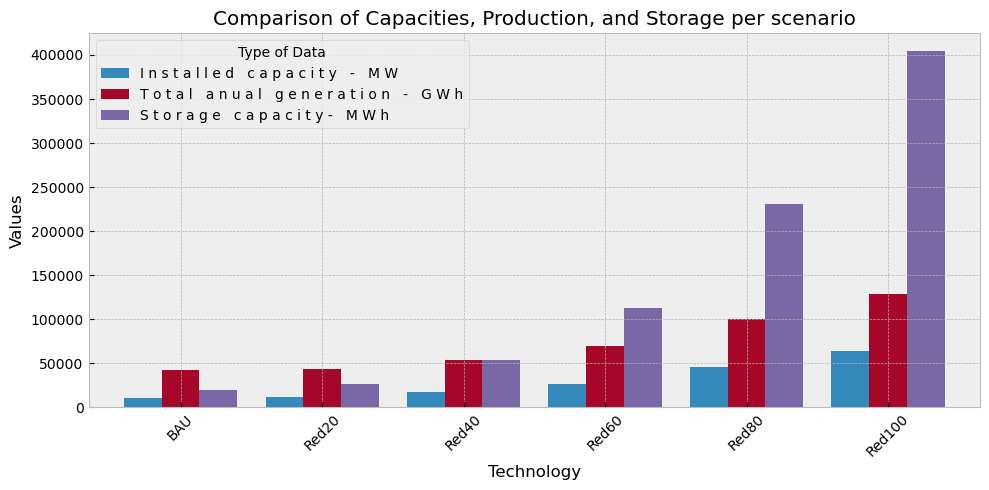

In [13]:
# Ensure the indexes are aligned for all DataFrames
combined_capacities_plot = combined_capacities.sort_index().sum()
combined_production_plot = combined_production.sort_index().sum()
combined_storage_capacities_plot = combined_storage_capacities.sort_index().sum()

# Combine the DataFrames into a single DataFrame
combined_all = pd.concat(
    [combined_capacities_plot, combined_production_plot, combined_storage_capacities_plot],
    axis=1,
    keys=['Installed capacity - MW', 'Total anual generation - GWh', 'Storage capacity- MWh']
)

# Flatten the MultiIndex columns for easier plotting
combined_all.columns = [' '.join(col).strip() for col in combined_all.columns.values]

# Plotting
ax = combined_all.plot(kind='bar', figsize=(10, 5), width=0.8)

# Set plot title and labels
ax.set_title('Comparison of Capacities, Production, and Storage per scenario')
ax.set_xlabel('Technology')
ax.set_ylabel('Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Type of Data')

# Display the plot
plt.tight_layout()
plt.show()

In [14]:
combined_all

,I n s t a l l e d c a p a c i t y - M W,T o t a l a n u a l g e n e r a t i o n - G W h,S t o r a g e c a p a c i t y - M W h
BAU,10079.066961,42523.010583,19346.802916
Red20,11513.637135,43536.796116,26197.134824
Red40,16680.948401,53038.451165,53840.771279
Red60,26795.760766,69716.835122,112255.164947
Red80,45413.037874,100552.620866,231133.689541
Red100,63971.267075,127930.450365,404373.917848
